In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pymc4 as pm
import arviz as az

import tensorflow_probability as tfp


In [19]:
@pm.model(auto_name=True)
def t_test():
    sigma = pm.HalfNormal(1)
    mu = pm.Normal(0, sigma)

model = t_test.configure()

model._forward_context.vars

In [3]:
model._forward_context.vars[0]._distribution.sample()

<tf.Tensor: id=109, shape=(), dtype=float32, numpy=-3.5687468>

In [4]:
model.forward_sample()

{'sigma': <tf.Tensor: id=136, shape=(), dtype=float32, numpy=1.1835041>,
 'mu': <tf.Tensor: id=158, shape=(), dtype=float32, numpy=-1.2197603>}

In [20]:
tf.function(model.make_log_prob_function())

In [7]:
func = model.make_log_prob_function()

sd = -tf.ones((1,))
mu = tf.ones((1,))

func(sd, mu)

<tf.Tensor: id=290, shape=(), dtype=float32, numpy=-4.5149107>

## HMC

In [13]:
def sample(model, nsteps=200, burnin=100, leapfrog_steps=10, compile=True):
    # Since HMC operates over unconstrained space, we need to transform the
    # samples so they live in real-space.
    random_variables = model._forward_context.vars
    unconstraining_bijectors = []
    inits = []
    for rv in random_variables:
        inits.append(tf.ones(rv.sample().shape))
        unconstraining_bijectors.append(tfp.bijectors.Identity())

    unnormalized_posterior_log_prob = model.make_log_prob_function()
    
    if compile:
        # compile logp to speed things up
        unnormalized_posterior_log_prob = tf.function(
            unnormalized_posterior_log_prob)

    # Initialize the step_size. (It will be automatically adapted.)
#     step_size = tf.get_variable(
#         name='step_size',
#         initializer=tf.constant(0.5, dtype=tf.float32),
#         trainable=False,
#         use_resource=True
#     )

    sample_chain = tfp.mcmc.sample_chain
    
    # Defining the HMC
    hmc = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            num_leapfrog_steps=leapfrog_steps,
            step_size=.5,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(100),
            state_gradients_are_stopped=False),
        bijector=unconstraining_bijectors)

    # Sampling from the chain.
    posterior_samples_tensor, kernel_results = sample_chain(
        num_results=nsteps,
        num_burnin_steps=burnin,
        current_state=inits,
        kernel=hmc)

    # Initialize any created variables.
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    
    evaluate(init_g)
    evaluate(init_l)
    
    *posterior_samples, kernel_results_ = evaluate([
        *posterior_samples_tensor,
        kernel_results,
    ])
    
    trace = {rv.name: arr for rv, arr in zip(random_variables, posterior_samples)}
    
    return az.dict_to_dataset(trace), kernel_results

In [14]:
%%time
trace, sampler_stats = sample(model, nsteps=1000, compile=True)

/Users/twiecki/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


AttributeError: 'float' object has no attribute 'assign_add'

In [7]:
trace

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 1000)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    sigma    (chain, draw) float32 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    mu       (chain, draw) float32 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Attributes:
    created_at:  2019-03-11T10:10:16.355586

/Users/twiecki/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


ValueError: cannot convert float NaN to integer

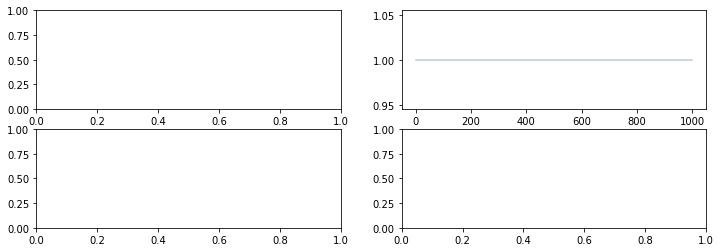

In [6]:
az.plot_trace(trace);

## NUTS

In [41]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

__all__ = [
    "kernel",
]


def nuts(target_log_prob_fn,
           current_state,
           step_size,
           seed=None,
           current_target_log_prob=None,
           current_grads_target_log_prob=None,
           name=None):
  """Simulates a No-U-Turn Sampler (NUTS) trajectory.
  Args:
    target_log_prob_fn: Python callable which takes an argument like
      `*current_state` and returns its (possibly unnormalized) log-density under
      the target distribution.
    current_state: List of `Tensor`s representing the states to simulate from.
    step_size: List of `Tensor`s representing the step sizes for the leapfrog
      integrator. Must have same shape as `current_state`.
    seed: Integer to seed the random number generator.
    current_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at the `current_state`.
    current_grads_target_log_prob: List of `Tensor`s representing gradient of
      `current_target_log_prob` with respect to `current_state`. Must have same
      shape as `current_state`.
    name: A name for the operation.
  Returns:
    next_state: List of `Tensor`s representing the next states of the NUTS
      trajectory. Has same shape as `current_state`.
    next_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at `next_state`.
    next_grads_target_log_prob: List of `Tensor`s representing the gradient of
      `next_target_log_prob` with respect to `next_state`.
  Raises:
    NotImplementedError: If the execution mode is not eager.
  """
  if not tf.executing_eagerly():
    raise NotImplementedError("`kernel` is only available in Eager mode.")

  with tf.compat.v1.name_scope(
      name,
      default_name="nuts_kernel",
      values=[
          current_state, step_size, seed, current_target_log_prob,
          current_grads_target_log_prob
      ]):
    with tf.compat.v1.name_scope("initialize"):
      current_state = [tf.convert_to_tensor(value=s) for s in current_state]
      step_size = [tf.convert_to_tensor(value=s) for s in step_size]
      value_and_gradients_fn = lambda *args: tfp.math.value_and_gradient(  # pylint: disable=g-long-lambda
          target_log_prob_fn, args)
      value_and_gradients_fn = _embed_no_none_gradient_check(
          value_and_gradients_fn)
      if (current_target_log_prob is None or
          current_grads_target_log_prob is None):
        (current_target_log_prob,
         current_grads_target_log_prob) = value_and_gradients_fn(*current_state)

      seed_stream = tfd.SeedStream(seed, "nuts_kernel")
      current_momentum = []
      for state_tensor in current_state:
        momentum_tensor = tf.random.normal(
            shape=tf.shape(input=state_tensor),
            dtype=state_tensor.dtype,
            seed=seed_stream())
        current_momentum.append(momentum_tensor)

      # Draw a slice variable u ~ Uniform(0, p(initial state, initial
      # momentum)) and compute log u. For numerical stability, we perform this
      # in log space where log u = log (u' * p(...)) = log u' + log
      # p(...) and u' ~ Uniform(0, 1).
      log_slice_sample = tf.math.log(tf.random.uniform([], seed=seed_stream()))
      log_slice_sample += _log_joint(current_target_log_prob,
                                     current_momentum)

      # Initialize loop variables. It comprises a collection of information
      # about a "reverse" state, a collection of information about a "forward"
      # state, a collection of information about the next state,
      # the trajectory's tree depth, the number of candidate states, and
      # whether to continue the trajectory.
      reverse_state = current_state
      reverse_target_log_prob = current_target_log_prob
      reverse_grads_target_log_prob = current_grads_target_log_prob
      reverse_momentum = current_momentum
      forward_state = current_state
      forward_target_log_prob = current_target_log_prob
      forward_grads_target_log_prob = current_grads_target_log_prob
      forward_momentum = current_momentum
      next_state = current_state
      next_target_log_prob = current_target_log_prob
      next_grads_target_log_prob = current_grads_target_log_prob
      depth = 0
      num_states = 1
      continue_trajectory = True

    while continue_trajectory:
      # Grow the No-U-Turn Sampler trajectory by choosing a random direction and
      # simulating Hamiltonian dynamics in that direction. This extends either
      # the forward or reverse state.
      direction = tfp.math.random_rademacher([], seed=seed_stream())
      if direction < 0:
        [
            reverse_state,
            reverse_target_log_prob,
            reverse_grads_target_log_prob,
            reverse_momentum,
            _,
            _,
            _,
            _,
            next_state_in_subtree,
            next_target_log_prob_in_subtree,
            next_grads_target_log_prob_in_subtree,
            num_states_in_subtree,
            continue_trajectory,
        ] = _build_tree(
            value_and_gradients_fn=value_and_gradients_fn,
            current_state=reverse_state,
            current_target_log_prob=reverse_target_log_prob,
            current_grads_target_log_prob=reverse_grads_target_log_prob,
            current_momentum=reverse_momentum,
            direction=direction,
            depth=depth,
            step_size=step_size,
            log_slice_sample=log_slice_sample,
            seed=seed_stream())
      else:
        [
            _,
            _,
            _,
            _,
            forward_state,
            forward_target_log_prob,
            forward_grads_target_log_prob,
            forward_momentum,
            next_state_in_subtree,
            next_target_log_prob_in_subtree,
            next_grads_target_log_prob_in_subtree,
            num_states_in_subtree,
            continue_trajectory,
        ] = _build_tree(
            value_and_gradients_fn=value_and_gradients_fn,
            current_state=forward_state,
            current_target_log_prob=forward_target_log_prob,
            current_grads_target_log_prob=forward_grads_target_log_prob,
            current_momentum=forward_momentum,
            direction=direction,
            depth=depth,
            step_size=step_size,
            log_slice_sample=log_slice_sample,
            seed=seed_stream())

      if continue_trajectory:
        # If the built tree did not terminate, accept the tree's next state
        # with a certain probability.
        accept_state_in_subtree = _random_bernoulli(
            [],
            probs=tf.minimum(1., num_states_in_subtree / num_states),
            dtype=tf.bool,
            seed=seed_stream())
        if accept_state_in_subtree:
          next_state = next_state_in_subtree
          next_target_log_prob = next_target_log_prob_in_subtree
          next_grads_target_log_prob = next_grads_target_log_prob_in_subtree

      # Continue the NUTS trajectory if the tree-building did not terminate, and
      # if the reverse-most and forward-most states do not exhibit a U-turn.
      has_no_u_turn = tf.logical_and(
          _has_no_u_turn(forward_state, reverse_state, forward_momentum),
          _has_no_u_turn(forward_state, reverse_state, reverse_momentum))
      continue_trajectory = continue_trajectory and has_no_u_turn
      num_states += num_states_in_subtree
      depth += 1

    return next_state, next_target_log_prob, next_grads_target_log_prob


def _build_tree(value_and_gradients_fn,
                current_state,
                current_target_log_prob,
                current_grads_target_log_prob,
                current_momentum,
                direction,
                depth,
                step_size,
                log_slice_sample,
                max_simulation_error=1000.,
                seed=None):
  """Builds a tree at a given tree depth and at a given state.
  The `current` state is immediately adjacent to, but outside of,
  the subtrajectory spanned by the returned `forward` and `reverse` states.
  Args:
    value_and_gradients_fn: Python callable which takes an argument like
      `*current_state` and returns a tuple of its (possibly unnormalized)
      log-density under the target distribution and its gradient with respect to
      each state.
    current_state: List of `Tensor`s representing the current states of the
      NUTS trajectory.
    current_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at the `current_state`.
    current_grads_target_log_prob: List of `Tensor`s representing gradient of
      `current_target_log_prob` with respect to `current_state`. Must have same
      shape as `current_state`.
    current_momentum: List of `Tensor`s representing the momentums of
      `current_state`. Must have same shape as `current_state`.
    direction: int that is either -1 or 1. It determines whether to perform
      leapfrog integration backwards (reverse) or forward in time respectively.
    depth: non-negative int that indicates how deep of a tree to build.
      Each call to `_build_tree` takes `2**depth` leapfrog steps.
    step_size: List of `Tensor`s representing the step sizes for the leapfrog
      integrator. Must have same shape as `current_state`.
    log_slice_sample: The log of an auxiliary slice variable. It is used
      together with `max_simulation_error` to avoid simulating trajectories with
      too much numerical error.
    max_simulation_error: Maximum simulation error to tolerate before
      terminating the trajectory. Simulation error is the
      `log_slice_sample` minus the log-joint probability at the simulated state.
    seed: Integer to seed the random number generator.
  Returns:
    reverse_state: List of `Tensor`s representing the "reverse" states of the
      NUTS trajectory. Has same shape as `current_state`.
    reverse_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at the `reverse_state`.
    reverse_grads_target_log_prob: List of `Tensor`s representing gradient of
      `reverse_target_log_prob` with respect to `reverse_state`. Has same shape
      as `reverse_state`.
    reverse_momentum: List of `Tensor`s representing the momentums of
      `reverse_state`. Has same shape as `reverse_state`.
    forward_state: List of `Tensor`s representing the "forward" states of the
      NUTS trajectory. Has same shape as `current_state`.
    forward_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at the `forward_state`.
    forward_grads_target_log_prob: List of `Tensor`s representing gradient of
      `forward_target_log_prob` with respect to `forward_state`. Has same shape
      as `forward_state`.
    forward_momentum: List of `Tensor`s representing the momentums of
      `forward_state`. Has same shape as `forward_state`.
    next_state: List of `Tensor`s representing the next states of the NUTS
      trajectory. Has same shape as `current_state`.
    next_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at `next_state`.
    next_grads_target_log_prob: List of `Tensor`s representing the gradient of
      `next_target_log_prob` with respect to `next_state`.
    num_states: Number of acceptable candidate states in the subtree. A state is
      acceptable if it is "in the slice", that is, if its log-joint probability
      with its momentum is greater than `log_slice_sample`.
    continue_trajectory: bool determining whether to continue the simulation
      trajectory. The trajectory is continued if no U-turns are encountered
      within the built subtree, and if the log-probability accumulation due to
      integration error does not exceed `max_simulation_error`.
  """
  if depth == 0:  # base case
    # Take a leapfrog step. Terminate the tree-building if the simulation
    # error from the leapfrog integrator is too large. States discovered by
    # continuing the simulation are likely to have very low probability.
    [
        next_state,
        next_target_log_prob,
        next_grads_target_log_prob,
        next_momentum,
    ] = _leapfrog(
        value_and_gradients_fn=value_and_gradients_fn,
        current_state=current_state,
        current_grads_target_log_prob=current_grads_target_log_prob,
        current_momentum=current_momentum,
        step_size=direction * step_size)
    next_log_joint = _log_joint(next_target_log_prob, next_momentum)
    num_states = tf.cast(next_log_joint > log_slice_sample, dtype=tf.int32)
    continue_trajectory = (next_log_joint >
                           log_slice_sample - max_simulation_error)
    return [
        next_state,
        next_target_log_prob,
        next_grads_target_log_prob,
        next_momentum,
        next_state,
        next_target_log_prob,
        next_grads_target_log_prob,
        next_momentum,
        next_state,
        next_target_log_prob,
        next_grads_target_log_prob,
        num_states,
        continue_trajectory,
    ]

  # Build a tree at the current state.
  seed_stream = tfd.SeedStream(seed, "build_tree")
  [
      reverse_state,
      reverse_target_log_prob,
      reverse_grads_target_log_prob,
      reverse_momentum,
      forward_state,
      forward_target_log_prob,
      forward_grads_target_log_prob,
      forward_momentum,
      next_state,
      next_target_log_prob,
      next_grads_target_log_prob,
      num_states,
      continue_trajectory,
  ] = _build_tree(value_and_gradients_fn=value_and_gradients_fn,
                  current_state=current_state,
                  current_target_log_prob=current_target_log_prob,
                  current_grads_target_log_prob=current_grads_target_log_prob,
                  current_momentum=current_momentum,
                  direction=direction,
                  depth=depth - 1,
                  step_size=step_size,
                  log_slice_sample=log_slice_sample,
                  seed=seed_stream())
  if continue_trajectory:
    # If the just-built subtree did not terminate, build a second subtree at
    # the forward or reverse state, as appropriate.
    if direction < 0:
      [
          reverse_state,
          reverse_target_log_prob,
          reverse_grads_target_log_prob,
          reverse_momentum,
          _,
          _,
          _,
          _,
          far_state,
          far_target_log_prob,
          far_grads_target_log_prob,
          far_num_states,
          far_continue_trajectory,
      ] = _build_tree(
          value_and_gradients_fn=value_and_gradients_fn,
          current_state=reverse_state,
          current_target_log_prob=reverse_target_log_prob,
          current_grads_target_log_prob=reverse_grads_target_log_prob,
          current_momentum=reverse_momentum,
          direction=direction,
          depth=depth - 1,
          step_size=step_size,
          log_slice_sample=log_slice_sample,
          seed=seed_stream())
    else:
      [
          _,
          _,
          _,
          _,
          forward_state,
          forward_target_log_prob,
          forward_grads_target_log_prob,
          forward_momentum,
          far_state,
          far_target_log_prob,
          far_grads_target_log_prob,
          far_num_states,
          far_continue_trajectory,
      ] = _build_tree(
          value_and_gradients_fn=value_and_gradients_fn,
          current_state=forward_state,
          current_target_log_prob=forward_target_log_prob,
          current_grads_target_log_prob=forward_grads_target_log_prob,
          current_momentum=forward_momentum,
          direction=direction,
          depth=depth - 1,
          step_size=step_size,
          log_slice_sample=log_slice_sample,
          seed=seed_stream())

    # Propose either `next_state` (which came from the first subtree and so is
    # nearby) or the new forward/reverse state (which came from the second
    # subtree and so is far away).
    num_states += far_num_states
    accept_far_state = _random_bernoulli(
        [],
        probs=far_num_states / num_states,
        dtype=tf.bool,
        seed=seed_stream())
    if accept_far_state:
      next_state = far_state
      next_target_log_prob = far_target_log_prob
      next_grads_target_log_prob = far_grads_target_log_prob

    # Continue the NUTS trajectory if the far subtree did not terminate either,
    # and if the reverse-most and forward-most states do not exhibit a U-turn.
    has_no_u_turn = tf.logical_and(
        _has_no_u_turn(forward_state, reverse_state, forward_momentum),
        _has_no_u_turn(forward_state, reverse_state, reverse_momentum))
    continue_trajectory = far_continue_trajectory and has_no_u_turn

  return [
      reverse_state,
      reverse_target_log_prob,
      reverse_grads_target_log_prob,
      reverse_momentum,
      forward_state,
      forward_target_log_prob,
      forward_grads_target_log_prob,
      forward_momentum,
      next_state,
      next_target_log_prob,
      next_grads_target_log_prob,
      num_states,
      continue_trajectory,
  ]


def _embed_no_none_gradient_check(value_and_gradients_fn):
  """Wraps value and gradients function to assist with None gradients."""
  @functools.wraps(value_and_gradients_fn)
  def func_wrapped(*args, **kwargs):
    """Wrapped function which checks for None gradients."""
    value, grads = value_and_gradients_fn(*args, **kwargs)
    if any(grad is None for grad in grads):
      raise ValueError("Gradient is None for a state.")
    return value, grads
  return func_wrapped


def _has_no_u_turn(state_one, state_two, momentum):
  """If two given states and momentum do not exhibit a U-turn pattern."""
  dot_product = sum([
      tf.reduce_sum(input_tensor=(s1 - s2) * m)
      for s1, s2, m in zip(state_one, state_two, momentum)
  ])
  return dot_product > 0


def _leapfrog(value_and_gradients_fn,
              current_state,
              current_grads_target_log_prob,
              current_momentum,
              step_size):
  """Runs one step of leapfrog integration."""
  mid_momentum = [
      m + 0.5 * step * g for m, step, g in
      zip(current_momentum, step_size, current_grads_target_log_prob)]
  next_state = [
      s + step * m for s, step, m in
      zip(current_state, step_size, mid_momentum)]
  next_target_log_prob, next_grads_target_log_prob = value_and_gradients_fn(
      *next_state)
  next_momentum = [
      m + 0.5 * step * g for m, step, g in
      zip(mid_momentum, step_size, next_grads_target_log_prob)]
  return [
      next_state,
      next_target_log_prob,
      next_grads_target_log_prob,
      next_momentum,
  ]


def _log_joint(current_target_log_prob, current_momentum):
  """Log-joint probability given a state's log-probability and momentum."""
  momentum_log_prob = -sum(
      [tf.reduce_sum(input_tensor=0.5 * (m**2.)) for m in current_momentum])
  return current_target_log_prob + momentum_log_prob


def _random_bernoulli(shape, probs, dtype=tf.int32, seed=None, name=None):
  """Returns samples from a Bernoulli distribution."""
  with tf.compat.v1.name_scope(name, "random_bernoulli", [shape, probs]):
    probs = tf.convert_to_tensor(value=probs)
    random_uniform = tf.random.uniform(shape, dtype=probs.dtype, seed=seed)
    return tf.cast(tf.less(random_uniform, probs), dtype)


In [49]:
def sample_nuts(model, nsteps=1000, burnin=500, step_size=.05, profile=False, compile=False):
    # Since HMC operates over unconstrained space, we need to transform the
    # samples so they live in real-space.
    random_variables = model._forward_context.vars
    unnormalized_posterior_log_prob = model.make_log_prob_function()
    inits = [0.] * len(random_variables)
    if compile:
        unnormalized_posterior_log_prob = tf.function(
            unnormalized_posterior_log_prob)

    posterior_samples = []
    target_log_prob = None
    grads_target_log_prob = None
    
    if profile:
        sampler = profiler(nuts)
    else:
        sampler = nuts
        
    step_size = tf.stack([step_size] * len(random_variables))
    
    for step in range(nsteps):
        if step % 10 == 0:
            print("Step", step)
        [
            inits,
            target_log_prob,
            grads_target_log_prob,
        ] = sampler(target_log_prob_fn=unnormalized_posterior_log_prob,
                   current_state=inits,
                   step_size=step_size,
                   seed=step,
                   current_target_log_prob=target_log_prob,
                   current_grads_target_log_prob=grads_target_log_prob)
        posterior_samples.append(inits)
   
    trace = {rv.name: arr for rv, arr in zip(random_variables, posterior_samples)}
    
    return az.dict_to_dataset(trace)

In [50]:
%%time
trace = sample_nuts(model, 100, profile=False)

Step 0
Step 10
Step 20
Step 30
Step 40
Step 50
Step 60
Step 70
Step 80
Step 90
CPU times: user 16.9 s, sys: 82.4 ms, total: 17 s
Wall time: 17.1 s


In [16]:
# with defun

In [52]:
%%time
trace = sample_nuts(model, 100, compile=True)

Step 0
Step 10
Step 20
Step 30
Step 40
Step 50
Step 60
Step 70
Step 80
Step 90
CPU times: user 6.65 s, sys: 214 ms, total: 6.87 s
Wall time: 6.59 s


ValueError: histogram(): `bins` should be a positive integer

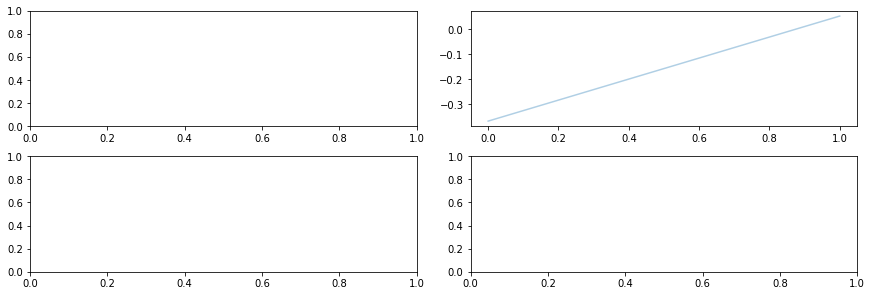

In [53]:
az.plot_trace(trace);

In [54]:
import pymc3 as pm3

with pm3.Model():
    mu = pm3.Normal('mu', 0, 1)
    sd = pm3.HalfNormal('sd', 1)
    pm3.Normal('y_0', 0, 2 * sd)
    pm3.Normal('y_1', mu, 2 * sd)
    pm3.sample()

Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1096.82draws/s]
/Users/twiecki/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
E0409 10:11:36.326550 4706502080 report.py:143] There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
E0409 10:11:36.327697 4706502080 report.py:143] There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
E0409 10:11:36.328660 4706502080 report.py:143] The estimated number of effective samples is smaller than 200 for some parameters.
